In [175]:
# Library Package
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

# Folder Path
files = './training/training_May-14-2019.csv'
dest_url ='./training/final_001.csv'

# Regular Expression
regex_wage = r'(\$[0-9,]{2,}[kK]?)'
regex_pday = r'(per day)|(p.d)'
regex_html = r'(<[^>]+>)'

%matplotlib inline

In [176]:
frame = pd.read_csv(files, sep='|')
frame.head()

,content,industries,location,title,type_empl,url,wage
0,Queensland Audit Office Investing in analytics...,Information & Communication Technology,"Brisbane, CBD & Inner Suburbs",Analyst - Audit Analytics Job in Brisbane - SEEK,Full Time,https://www.seek.com.au/job/38867796?type=prom...,NaN
1,Queensland Audit Office Investing in analytics...,Government & Defence,"Brisbane, CBD & Inner Suburbs",Analyst - Audit Analytics Job in Brisbane - SEEK,Full Time,https://www.seek.com.au/job/39017806?type=stan...,NaN
2,Queensland Audit Office Investing in analytics...,Government & Defence,"Brisbane, CBD & Inner Suburbs",Analyst - Audit Analytics Job in Brisbane - SEEK,Full Time,https://www.seek.com.au/job/39017819?type=stan...,NaN
3,Queensland Audit Office Investing in analytics...,Government & Defence,"Brisbane, CBD & Inner Suburbs",Analyst - Audit Analytics Job in Brisbane - SEEK,Full Time,https://www.seek.com.au/job/39017831?type=stan...,NaN
4,Queensland Audit Office Investing in analytics...,Government & Defence,"Brisbane, CBD & Inner Suburbs",Analyst - Audit Analytics Job in Brisbane - SEEK,Full Time,https://www.seek.com.au/job/39017842?type=stan...,NaN


In [177]:
# Drop NaN content due to 410 url
frame = frame.dropna(subset=['content'])

## 1. Wage Column

In [178]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5313 entries, 0 to 5473
Data columns (total 7 columns):
content       5313 non-null object
industries    5313 non-null object
location      5313 non-null object
title         5313 non-null object
type_empl     5313 non-null object
url           5313 non-null object
wage          1993 non-null object
dtypes: object(7)
memory usage: 332.1+ KB


In [179]:
frame['wage'].unique()

array([nan, 'Fantastic New Opportunity!!',
       'Amazing travel benefits and industry discounts!', ...,
       '$90k - $100k per annum + super + bonus',
       '[\'Salary and employment conditions are in accordance with the Social, Community, Home Care and Disability Services Industry Award 2010, Level 7, with capacity for salary packaging and the provision of a fully maintained motor vehicle available for\\n          private use. Superannuation is paid in addition at 9.5%.\', \'Salary and employment conditions are in accordance with the Social, Community, Home Care and Disability Services Industry Award 2010, Level 7, with capacity for salary packaging and the provision of a fully maintained motor vehicle available for private use. Superannuation is paid in addition at 9.5%.\', \'\\n        window.SEEK_CONFIG = {"SEEK_JOB_TRACKING_URL":"https:\\\\u002F\\\\u002Ftracking.engineering.cloud.seek.com.au\\\\u002Fa.png","SEEK_METRICS_PREFIX":"discover","SEEK_API_EVENT_CAPTURE_ENDPOINT":"ht

In [180]:
### Special Cases for training.csv

# 96,000k
# https://www.seek.com.au/job/39003699?type=standout&searchrequesttoken=1907a61e-aba7-41b1-b94a-37f7f06e0f7c

# 130,000-150,000k
# https://www.seek.com.au/job/38915724?type=standout&searchrequesttoken=d0b07562-538a-480d-ab14-3078fa096fbe

# 90,000k
# https://www.seek.com.au/job/38963567?type=standout&searchrequesttoken=d6ff298d-f248-4cc1-866b-0d7b1c2f1b27

In [181]:
# Split Url out of content
def get_wage(regex, sample):
    result = re.findall(regex, sample)
    per_day = re.search(regex_pday,sample)

    if result:
        # Basic clean.
        result = [value.strip("$").replace(",","").lower() for value in result]
        print("=======================B4: ",result)
        
        # findall might return an duplicate values
        # Reduce the length into 2 first values
        if len(result) >= 2:
            result = result[:2]
            print("I-If: ",result)
            
            # Case-of "k" appears 2times
            if ("k" in result[0]) and ("k" in result[-1]):
                final = int(result[0].strip("k")) + int(result[-1].strip("k"))
                final = final/2
                # Treat special cases
                if final < 1000:
                    final = final*1000
            
            # Case-of "k" appears 1time at last.
            elif ("k" not in result[0]) and ("k" in result[-1]):
                k_value = int(result[-1].strip("k"))
                if k_value < 1000:
                    k_value = k_value*1000
                print(type(k_value))
                print(type(result[0]))
                
                final = (int(result[0]) + k_value)/2
            
            # Case-of "k" appears 1time at first.
            elif ("k" in result[0]) and ("k" not in result[-1]):
                k_value = int(result[0].strip("k"))
                if k_value < 1000:
                    k_value = k_value*1000
                
                final = (k_value + int(result[-1]))/2
                
            elif len(result[0]) < 5 and len(result[-1]) < 5:
                final = np.mean([int(value)*260 for value in result])
                if not per_day:
                    final = final*7.5
            else:
                final = np.mean([int(value) for value in result])
                
            print("O-If: ",final)
            return final
        else:
            result = result[0]
            print("I-Else: ",result)
            
            if "k" in result:
                k_value = int(result.strip("k"))
                # Treat special case
                if k_value < 1000:
                    result = k_value*1000
                else:
                    result = k_value
            elif len(result) < 5:
                result = int(result)*260
                if not per_day:
                    result = int(result)*7.5
            else:
                result = int(result)
            print("O-Else: ", result)
            print("========\n")
            return result
    else:
        return 0

In [182]:
frame['wage'] = frame['wage'].map(lambda row: get_wage(regex_wage,str(row)))

=======================B4:  ['130k', '150k']
I-If:  ['130k', '150k']
O-If:  140000.0
=======================B4:  ['111526', '116836']
I-If:  ['111526', '116836']
O-If:  114181.0
=======================B4:  ['111526', '116836']
I-If:  ['111526', '116836']
O-If:  114181.0
=======================B4:  ['82748', '92747']
I-If:  ['82748', '92747']
O-If:  87747.5
=======================B4:  ['82748', '92747']
I-If:  ['82748', '92747']
O-If:  87747.5
=======================B4:  ['93709', '106214']
I-If:  ['93709', '106214']
O-If:  99961.5
=======================B4:  ['650', '693']
I-If:  ['650', '693']
O-If:  174590.0
=======================B4:  ['150', '175k']
I-If:  ['150', '175k']
<class 'int'>
<class 'str'>
O-If:  87575.0
=======================B4:  ['130000', '170000']
I-If:  ['130000', '170000']
O-If:  150000.0
=======================B4:  ['135k']
I-Else:  135k
O-Else:  135000

=======================B4:  ['67542', '90982']
I-If:  ['67542', '90982']
O-If:  79262.0
=======================

I-If:  ['75000', '85000']
O-If:  80000.0
=======================B4:  ['65', '70']
I-If:  ['65', '70']
O-If:  131625.0
=======================B4:  ['60', '79']
I-If:  ['60', '79']
O-If:  135525.0
=======================B4:  ['120k', '150k']
I-If:  ['120k', '150k']
O-If:  135000.0
=======================B4:  ['200']
I-Else:  200
O-Else:  390000.0

=======================B4:  ['50', '57']
I-If:  ['50', '57']
O-If:  104325.0
=======================B4:  ['110k', '115k']
I-If:  ['110k', '115k']
O-If:  112500.0
=======================B4:  ['150k']
I-Else:  150k
O-Else:  150000

=======================B4:  ['120k', '160k']
I-If:  ['120k', '160k']
O-If:  140000.0
=======================B4:  ['130k']
I-Else:  130k
O-Else:  130000

=======================B4:  ['130k']
I-Else:  130k
O-Else:  130000

=======================B4:  ['130k']
I-Else:  130k
O-Else:  130000

=======================B4:  ['180k', '220k']
I-If:  ['180k', '220k']
O-If:  200000.0
=======================B4:  ['150k']
I-Else:  15

O-Else:  103000

=======================B4:  ['800']
I-Else:  800
O-Else:  208000

=======================B4:  ['118000', '134599']
I-If:  ['118000', '134599']
O-If:  126299.5
=======================B4:  ['118000', '134599']
I-If:  ['118000', '134599']
O-If:  126299.5
=======================B4:  ['55000', '64999']
I-If:  ['55000', '64999']
O-If:  59999.5
=======================B4:  ['140k', '210k']
I-If:  ['140k', '210k']
O-If:  175000.0
=======================B4:  ['120k', '130k']
I-If:  ['120k', '130k']
O-If:  125000.0
=======================B4:  ['120000', '150000']
I-If:  ['120000', '150000']
O-If:  135000.0
=======================B4:  ['100000', '110000']
I-If:  ['100000', '110000']
O-If:  105000.0
=======================B4:  ['60k', '70k']
I-If:  ['60k', '70k']
O-If:  65000.0
=======================B4:  ['90k', '110k']
I-If:  ['90k', '110k']
O-If:  100000.0
=======================B4:  ['35']
I-Else:  35
O-Else:  68250.0

=======================B4:  ['550', '600']
I-If:  ['550', '

=======================B4:  ['85000', '120000']
I-If:  ['85000', '120000']
O-If:  102500.0
=======================B4:  ['110000']
I-Else:  110000
O-Else:  110000

=======================B4:  ['100k']
I-Else:  100k
O-Else:  100000

=======================B4:  ['73k', '98']
I-If:  ['73k', '98']
O-If:  36549.0
=======================B4:  ['73k', '98']
I-If:  ['73k', '98']
O-If:  36549.0
=======================B4:  ['99k', '103k']
I-If:  ['99k', '103k']
O-If:  101000.0
=======================B4:  ['110000']
I-Else:  110000
O-Else:  110000

=======================B4:  ['160k']
I-Else:  160k
O-Else:  160000

=======================B4:  ['120k', '150k']
I-If:  ['120k', '150k']
O-If:  135000.0
=======================B4:  ['15900', '15900', '15900', '15900']
I-If:  ['15900', '15900']
O-If:  15900.0
=======================B4:  ['83403', '92026']
I-If:  ['83403', '92026']
O-If:  87714.5
=======================B4:  ['83403', '92026']
I-If:  ['83403', '92026']
O-If:  87714.5
=======================

In [183]:
frame['wage'] = frame['wage'].astype('int64')
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5313 entries, 0 to 5473
Data columns (total 7 columns):
content       5313 non-null object
industries    5313 non-null object
location      5313 non-null object
title         5313 non-null object
type_empl     5313 non-null object
url           5313 non-null object
wage          5313 non-null int64
dtypes: int64(1), object(6)
memory usage: 332.1+ KB


In [184]:
frame['wage'].unique()

array([      0,  140000,  114181,   87747,   99961,  174590,   87575,
        150000,  135000,   79262,  210000,  102000,   88345,  120000,
         85572,   67499,   92924,   95000,  104124,  102365,   78000,
        201500,  173550,  112529,  117537,  100534,   80000,   55000,
        115000,  204750,  136500,   97500,  189150,  146250,  182000,
        104999,   59999,  202800,   82875,  114999,   90000,  185250,
        108225,   92500,  182325,   84825,   83850,  143000,  102291,
          8320,  188890,  208000,   99500,   89999,  107499,  224250,
        117975,  113100,  179400,  175500,  125000,   60000, 1560000,
        390000,  170000,   85000,   82500,  215000,  156000,   75135,
        200000,   82499,  157500, 1291875,   35532,  130000, 1218750,
        106316,   86578, 1413750,  116978,  149999,  149500,   87499,
         69580,  100000,  108480,   77500,   79999,  103120,  110000,
       1267500,   57000,  107500,   75000,  169999,  160000,  234000,
        104000,  132

In [185]:
frame[frame['wage'] > 10000000]['url']

Series([], Name: url, dtype: object)

In [186]:
frame1 = frame[frame['wage'] > 0]
frame1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 27 to 5466
Data columns (total 7 columns):
content       1184 non-null object
industries    1184 non-null object
location      1184 non-null object
title         1184 non-null object
type_empl     1184 non-null object
url           1184 non-null object
wage          1184 non-null int64
dtypes: int64(1), object(6)
memory usage: 74.0+ KB


## 2. Title column

In [143]:
def get_wage_from_header(sample):
    result = re.findall(r'(\$[0-9,]{2,}[kK]?)', title)
    if len(result):
#         print(result)
        return result
    return 0

In [144]:
frame['wage_title'] = frame['title'].map(get_wage_from_header)

In [145]:
frame['wage_title'] = frame['wage_title'].map(lambda row: get_wage(regex_wage,str(row)))

In [146]:
frame['wage_title'].value_counts()

0    5313
Name: wage_title, dtype: int64

## 3. Other column

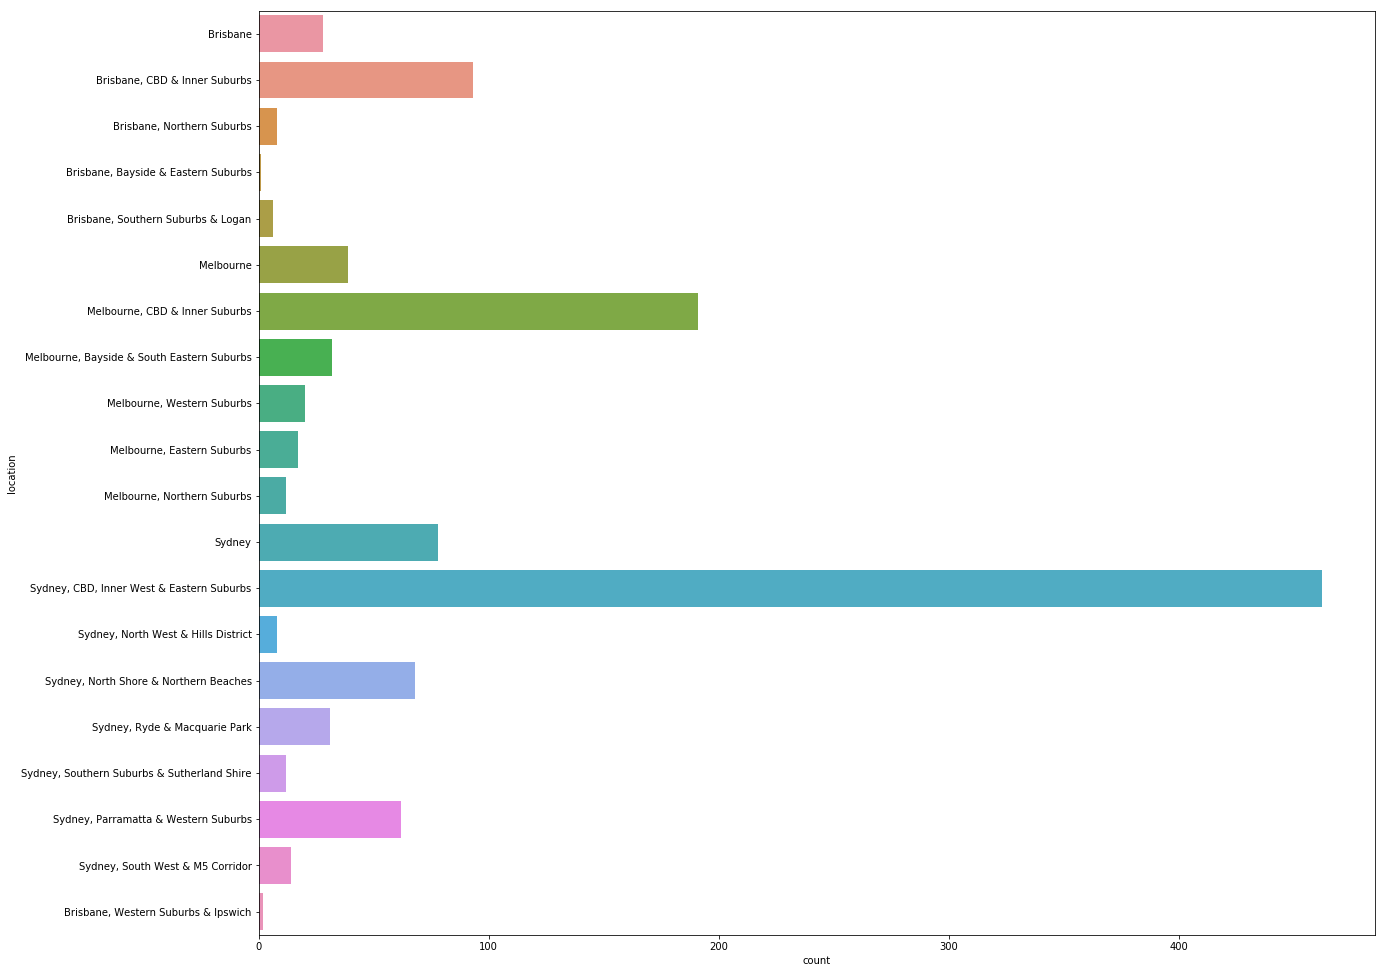

In [159]:
frame1['location'].value_counts()

fig = plt.subplots(figsize=(20,17))
sns.countplot(y='location',data=frame1)

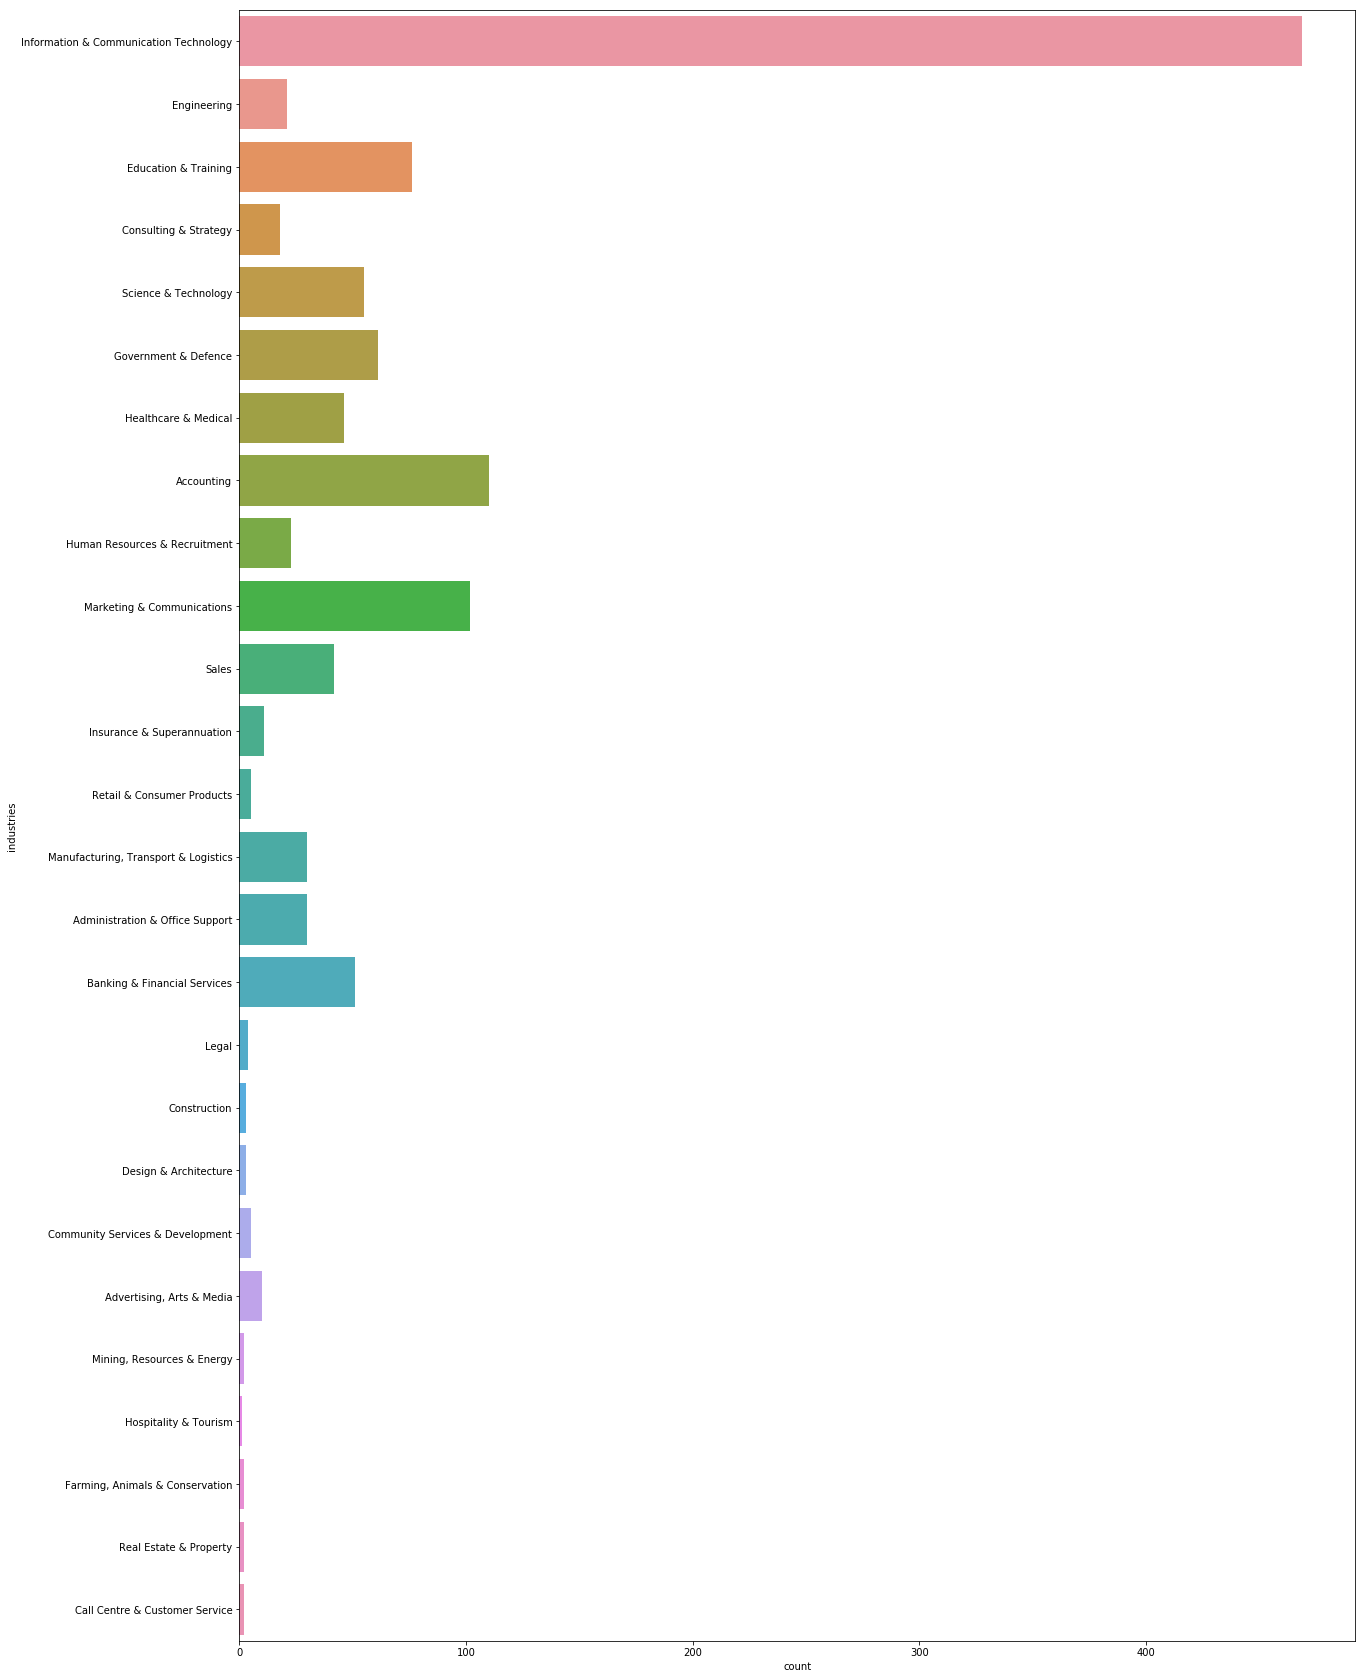

In [155]:
frame1['industries'].value_counts()
fig = plt.subplots(figsize=(20,30))
sns.countplot(y='industries', data=frame1)

In [41]:
frame1['content'] = frame1['content'].map(lambda row: re.sub(regex_html,'',row))

C:\Users\Shaynie\Anaconda3\envs\capstone_app\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 4. Other Column

In [42]:
no = 0
print(frame1['url'].iloc[no])
print("======================")
print(frame1['wage'].iloc[no])
print("======================")
frame1['content'].iloc[no]

https://www.seek.com.au/job/38935642?type=standard&searchrequesttoken=a3acebea-bf51-4959-b5b1-2e1fb9344efb
140000


"Senior Analytics Lead - Claims | Cognos | Tableau | SQL | Redshift (Insurance Domain) The Role The Analyst Consultant is responsible for the planning, management, production, preparation, and analysis of various reports and other pilots/projects. This individual will act as a key analytics expert within the team by providing vision and guidance, acquiring data, designing appropriate analytic methodologies, troubleshooting problems identified within the database tables, and facilitating issue resolution. Responsibilities include developing and implementing new and innovative approaches or methodologies to expand or improve current business techniques for measuring and evaluating programs, enhancing the credibility of our client's measurement techniques for clients and presenting cutting edge research in support of our value proposition. Responsibilities: Provide leadership and strategy in relationship to data utilization for business stream Prepare presentations and present findings to

In [43]:
frame1.head()

,content,industries,location,title,type_empl,url,wage
27,Senior Analytics Lead - Claims | Cognos | Tabl...,Information & Communication Technology,Brisbane,"Claims Analytics Lead - Cognos, Tableau, Redsh...",Full Time,https://www.seek.com.au/job/38935642?type=stan...,140000
36,The Data Engineer (Cloud/Data Lake) will play ...,Information & Communication Technology,"Brisbane, CBD & Inner Suburbs",Data Engineer - Cloud / Data Lake Job in Brisb...,Full Time,https://www.seek.com.au/job/39015517?type=stan...,114181
51,The Data Architect is responsible for enterpri...,Information & Communication Technology,"Brisbane, CBD & Inner Suburbs",Data Architect Job in Brisbane - SEEK,Full Time,https://www.seek.com.au/job/39015289?type=stan...,114181
53,About AFSA The Australian Financial Security A...,Information & Communication Technology,"Brisbane, CBD & Inner Suburbs",Applications Developer Enterprise Data Warehou...,Full Time,https://www.seek.com.au/job/38935314?type=stan...,87747
54,About AFSA The Australian Financial Security A...,Information & Communication Technology,"Brisbane, CBD & Inner Suburbs",Applications Developer Enterprise Data Warehou...,Full Time,https://www.seek.com.au/job/38935330?type=stan...,87747


In [187]:
frame1.to_csv(dest_url,sep='|',index=False)